In [2]:
!sudo apt install libdb5.3-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  db5.3-doc
The following NEW packages will be installed:
  libdb5.3-dev
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 762 kB of archives.
After this operation, 3,146 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdb5.3-dev amd64 5.3.28-13.1ubuntu1 [762 kB]
Fetched 762 kB in 1s (1,091 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libdb5.3-dev.
(Read

In [ ]:
!pip install --upgrade setuptools

In [3]:
!pip install gutenberg


Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (40.8.0)
    100% |████████████████████████████████| 245kB 7.9MB/s 
    100% |████████████████████████████████| 348kB 25.6MB/s 
    100% |████████████████████████████████| 1.0MB 20.6MB/s 
    100% |████████████████████████████████| 51kB 18.9MB/s 
    100% |████████████████████████████████| 573kB 24.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/8e/cd/75/4bc6f16541a1b7a69b02168da567695b2271c23ac4a0a0a453
  Stored in directory: /root/.cache/pip/wheels/11/b8/b3/fa84db10bf8c563e4ba1a72837a0946d123f12adb34b164bf5
  Stored in directory: /root/.cache/pip/wheels/f9/71/46/604b8a4f0a04b513f5799c974b556c1de19a70fde41d25672b
  Stored in directory: /root/.cache/pip/wheels/15/35/25/dbcb848832ccb1a4b4ad23f529badfd3bce9bf88017f7ca510
Successfully built gutenberg bsddb3 alembic Mako


In [2]:
!pip install keras

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl


In [40]:
try:
    GUTENBERG = True
    from gutenberg.acquire import load_etext
    from gutenberg.query import get_etexts, get_metadata
    from gutenberg.acquire import get_metadata_cache
    from gutenberg.acquire.text import UnknownDownloadUriException
    from gutenberg.cleanup import strip_headers
    from gutenberg._domain_model.exceptions import CacheAlreadyExistsException
except ImportError:
    GUTENBERG = False
    print('Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg')
from keras.models import Input, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.wrappers import TimeDistributed
import keras.callbacks
import keras.backend as K
import scipy.misc
import json

import os, sys
import re
import PIL
from PIL import ImageDraw

from keras.optimizers import RMSprop
import random
import numpy as np
import tensorflow as tf
from keras.utils import get_file

from IPython.display import clear_output, Image, display, HTML
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

In [8]:
if GUTENBERG:
    cache = get_metadata_cache()
    try:
        cache.populate()
    except CacheAlreadyExistsException:
        pass

In [9]:
if GUTENBERG:
    for text_id in get_etexts('author', 'Shakespeare, William'):
        print(text_id, list(get_metadata('title', text_id))[0])

100 The Complete Works of William Shakespeare
10281 Antony's Address over the Body of Caesar
From Julius Caesar
1100 The First Part of Henry the Sixth
1101 The Second Part of King Henry the Sixth
10606 The Tragedie of Hamlet, Prince of Denmark
A Study with the Text of the Folio of 1623
1102 The Third Part of King Henry the Sixth
1103 King Richard III
1041 Shakespeare's Sonnets
1104 The Comedy of Errors
1105 The Sonnets
1106 The Tragedy of Titus Andronicus
1045 Venus and Adonis
1107 The Taming of the Shrew
1108 The Two Gentlemen of Verona
1109 Love's Labour's Lost
1110 King John
1111 King Richard the Second


In [10]:
if GUTENBERG:
    shakespeare = strip_headers(load_etext(100))
else:
    path = get_file('shakespeare', 'https://storage.googleapis.com/deep-learning-cookbook/100-0.txt')
    shakespeare = open(path).read()
training_text = shakespeare.split('\nTHE END', 1)[-1]
len(training_text)

5537603

In [ ]:
chars = list(sorted(set(training_text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
len(chars)

94

In [ ]:
def char_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model = char_rnn_model(len(chars), num_layers=2, num_nodes=640, dropout=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 94)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1881600   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 94)          60254     
Total params: 5,221,214
Trainable params: 5,221,214
Non-trainable params: 0
_________________________________________________________________


In [ ]:
CHUNK_SIZE = 160

def data_generator(all_text, char_to_idx, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    y = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(all_text) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, len(char_to_idx)))
            for i in range(chunk_size + 1):
                chunk[i, char_to_idx[all_text[idx + i]]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(training_text, char_to_idx, 4, chunk_size=CHUNK_SIZE))

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0

In [18]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(training_text, char_to_idx, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(training_text) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/40
 - 109s - loss: 2.9157 - acc: 0.2815
Epoch 2/40
 - 105s - loss: 2.2030 - acc: 0.4714
Epoch 3/40
 - 105s - loss: 2.1948 - acc: 0.4748
Epoch 4/40
 - 105s - loss: 2.2376 - acc: 0.4662
Epoch 5/40
 - 109s - loss: 2.8949 - acc: 0.2875


In [20]:
with open('zoo/06/shakespeare.json', 'w') as fout:
    json.dump({
        'chars': ''.join(chars),
        'char_to_idx': char_to_idx,
        'chunk_size': CHUNK_SIZE,
    }, fout)
model.save('zoo/06/shakespeare.h5')

In [21]:
def generate_output(model, training_text, start_index=None, diversity=None, amount=400):
    if start_index is None:
        start_index = random.randint(0, len(training_text) - CHUNK_SIZE - 1)
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    for i in range(amount):
        x = np.zeros((1, len(generated), len(chars)))
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        next_char = chars[next_index]
        yield next_char

        generated += next_char
    return generated

for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()
        


    But this I know- they have demean'd themselves
    Like men born to renown by life or death.
    Three times did Richard make a lane to me,
    And thrice #                                                                                                                                                                                                                                                                                                                                                                                                                


In [22]:
def find_python(rootdir):
    matches = []
    for root, dirnames, filenames in os.walk(rootdir):
        for fn in filenames:
            if fn.endswith('.py'):
                matches.append(os.path.join(root, fn))

    return matches
#  + find_python(os.path.join(sys.executable.rsplit('/', 2)[0], 'lib'))
srcs = find_python(random.__file__.rsplit('/', 1)[0])
len(srcs)

9512

In [23]:
def replacer(value):
    value = ''.join(ch for ch in value if ord(ch) < 127)
    if not ' ' in value:
        return value
    if sum(1 for ch in value if ch.isalpha()) > 6:
        return 'MSG'
    return value


def replace_literals(st):
    res = []
    start_text = start_quote = i = 0
    quote = ''
    while i < len(st):
        if quote:
            if st[i: i + len(quote)] == quote:
                quote = ''
                start_text = i
                res.append(replacer(st[start_quote: i]))
        elif st[i] in '"\'':
            quote = st[i]
            if i < len(st) - 2 and st[i + 1] == st[i + 2] == quote:
                quote = 3 * quote
            start_quote = i + len(quote)
            res.append(st[start_text: start_quote])
        if st[i] == '\n' and len(quote) == 1:
            start_text = i
            res.append(quote)
            quote = ''
        if st[i] == '\\':
            i += 1
        i += 1
    return ''.join(res) + st[start_text:]

#replace_literals('print("hel\\"lo")') + replace_literals("print('hel\\'lo world')")
replace_literals('this = "wrong\n')

'this = ""\n'

In [24]:
COMMENT_RE = re.compile('#.*')
python_code = []
for fn in srcs:
    try:
        with open(fn, 'r') as fin:
            src = fin.read()
    except UnicodeDecodeError:
        print('Could not read %s' % fn)
    src = replace_literals(src)
    src = COMMENT_RE.sub('', src)
    python_code.append(src)

python_code = '\n\n\n'.join(python_code)
len(python_code)

Could not read /home/super/anaconda3/envs/ML/lib/python3.6/site-packages/IPython/core/tests/nonascii.py


81763474

In [25]:
py_chars = list(sorted(set(python_code)))
py_char_to_idx = {ch: idx for idx, ch in enumerate(py_chars)}
len(py_chars)

98

In [26]:
py_model = char_rnn_model(len(py_chars), num_layers=2, num_nodes=640, dropout=0)
py_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 98)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 640)         1891840   
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 98)          62818     
Total params: 5,234,018
Trainable params: 5,234,018
Non-trainable params: 0
_________________________________________________________________


In [27]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
py_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 1525s - loss: 2.4727 - acc: 0.4464
Epoch 2/40
 - 1550s - loss: 1.9531 - acc: 0.5750
Epoch 3/40
 - 1541s - loss: 1.9239 - acc: 0.5841
Epoch 4/40
 - 1560s - loss: 1.9033 - acc: 0.5900
Epoch 5/40
 - 1594s - loss: 2.0104 - acc: 0.5604
Epoch 6/40
 - 1591s - loss: 2.0587 - acc: 0.5447
Epoch 7/40
 - 1588s - loss: 2.0388 - acc: 0.5505


In [29]:
def generate_code(model, start_with='\ndef ', end_with='\n\n', diversity=1.0):
    generated = start_with
    yield generated
    for i in range(2000):
        x = np.zeros((1, len(generated), len(py_chars)))
        for t, char in enumerate(generated):
            x[0, t, py_char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        
        preds = np.asarray(preds[len(generated) - 1]).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        next_index = np.argmax(probas)        
        next_char = py_chars[next_index]
        yield next_char

        generated += next_char
        if generated.endswith(end_with):
            break
st = ''
for i in range(20):
    for ch in generate_code(py_model):
        sys.stdout.write(ch)
        st += ch
    print()



def UTASYIGn_p viou oo  utra
    re_resut_ri_hmal = resultity_or_flaters_emitsneed]
r = imageed.AndOfOptr_gnuh()
val = RootPtxINrread( elif    tmminiu
hh=npcap ):
    if hstate dw[
            ipmite']''rore':
   window_shun
    retueepale_tt =pandli)
f(ir = 0hrrpos(ht =losenoul - taflig _a %i, us,cr zyout, (_iw_ari,ynals))
   executeerpchts = func_cub.omr("pyg =eao4)
  non_fy_valuz = 'image' + fytGbF'
 pair = pyfi = {np\ ' y
       tshap moders. To. += HISTfraeou
        ,   opti = g +if 'As i -,  H'r"Modefisit,va: VeearCycleRestColo * ssn2[morcel',tf =o +1 /]
        ival=onexpdefects_format * 1)



def "   uni % s  , ly r and  (refruileva compa andflk >= region) and   ] ==   default =-tt e.send_co = 1S1 *]:
[_n+uuXpointe  



def testate2_fmd(set =f ny(t + 1]):exec
  a from @test import test_ a pU_SYS_BIND_bf=rflline_ ianSamolegoos_exe\le .s order()
    errorcodsnameed = pa_status_ph
    engining=updx,



def a,(a3centstat == ba + one(br2),
      .1_ * 1, 3),  
'(ar, :', a.outputs)

In [30]:
BATCH_SIZE = 512

flat_model = char_rnn_model(len(py_chars), num_layers=1, num_nodes=512, dropout=0)

early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

flat_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) / (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 489s - loss: 2.7627 - acc: 0.3772
Epoch 2/40
 - 497s - loss: 2.0918 - acc: 0.5375
Epoch 3/40
 - 504s - loss: 2.0394 - acc: 0.5520
Epoch 4/40
 - 499s - loss: 2.0445 - acc: 0.5522
Epoch 5/40
 - 496s - loss: 2.0073 - acc: 0.5614
Epoch 6/40
 - 500s - loss: 2.0350 - acc: 0.5543
Epoch 7/40
 - 498s - loss: 2.0334 - acc: 0.5544
Epoch 8/40
 - 496s - loss: 2.0398 - acc: 0.5531


In [56]:
example_code = 'if a == 2:\n    b=1\nelse:\n    b=2\n'
#example_code = 'a=(2 * 3)\nb=(4 * 6 + 7)\nreturn C'

def activations(model, code):
    x = np.zeros((1, len(code), len(py_char_to_idx)))
    for t, char in enumerate(code):
        x[0, t, py_char_to_idx[char]] = 1.
    output = model.get_layer('lstm_layer_1').output
    f = K.function([model.input], [output])
    return f([x])[0][0]

act = activations(flat_model, example_code)
act.shape

(33, 512)

In [66]:
def interesting_neurons(act):
    res = []
    for n in np.argmax(act, axis=1):
        if not n in res:
            res.append(n)
    return res

neurons = interesting_neurons(act)
len(neurons)

2

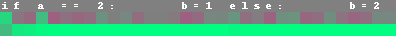

In [72]:
def visualize_neurons(neurons, code, act, cell_size=12):
    img = np.full((len(neurons) + 1, len(code), 3), 128)
    scores = (act[:, neurons].T + 1) / 2
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores
    

    f = BytesIO()
    #img = scipy.misc.imresize(img, float(cell_size), interp='nearest')
    pil_img = PIL.Image.fromarray(np.uint8(img))
    pil_img = pil_img.resize((pil_img.size[0]*cell_size, pil_img.size[1]*cell_size), PIL.Image.NEAREST)
    draw = ImageDraw.Draw(pil_img)
    for idx, ch in enumerate(code):
        draw.text((idx * cell_size + 2, 0), ch)
    pil_img.save(f, 'png')
    return Image(data=f.getvalue())

img = visualize_neurons(neurons, example_code, act)
display(img)

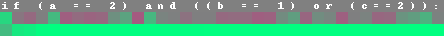

In [73]:
def image_for_code(code):
    act = activations(flat_model, code)
    neurons = interesting_neurons(act)
    return visualize_neurons(neurons, code, act)

display(image_for_code('if (a == 2) and ((b == 1) or (c==2)):'))

In [74]:
code = 'if (a == 2) and ((b == 1) or (c==2)):'
mask = '   ________     ____________________ '
act = activations(flat_model, code)
positive = [idx for idx, ch in enumerate(mask) if ch == '_']
negative = [idx for idx, ch in enumerate(mask) if ch != '_']

neurons = np.argsort(act[positive].sum(axis=0) - act[negative].sum(axis=0))[-5:]

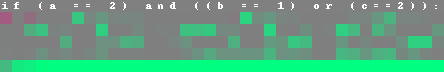

In [75]:
img = visualize_neurons(neurons, code, act)
display(img)

In [76]:
neurons

array([ 44,   0, 222, 454, 501])

In [77]:
act[negative, 108].sum()

0.09292999

In [78]:
x0 = 0
x1 = 0
for idx, ch in enumerate(mask):
    if ch == '_':
        x0 += act[idx, 108]
    else:
        x1 += act[idx, 108]
x0, x1

(0.006925315210537519, 0.09292998909950256)